VOY A GRAFICAR LOS MAXIMOS PARA CADA GRB



In [ ]:
import os, glob, csv
import numpy as np
import pandas as pd
import healpy as hp
from astropy.io import fits
from concurrent.futures import ProcessPoolExecutor
from scipy.stats import norm

# ========================= Configuración =========================
base_path  = "/lustre/hawcz01/scratch/userspace/jorgeamontes/GRB_KN/data/healpixz=0_alfa1.5"
input_csv  = "/lustre/hawcz01/scratch/userspace/jorgeamontes/GRB_KN/data/ULs/config/Data/GRB_List_z=0.csv"
min_value  = -6
sig_candidates = ["SIGNIFICANCE","significance","SIG","VALUE","val","Val"]
max_workers = 20

def _read_sig_column(hdul):
    """Lee la columna de significancia o la imagen primaria."""
    if len(hdul) > 1 and hdul[1].header:
        ordering = (hdul[1].header.get("ORDERING", "RING") or "RING").strip().upper()
    else:
        ordering = (hdul[0].header.get("ORDERING", "RING") or "RING").strip().upper()
    if len(hdul) > 1 and hdul[1].data is not None:
        cols = list(hdul[1].columns.names)
        low  = [c.lower() for c in cols]
        for cand in sig_candidates:
            if cand in cols:
                return np.asarray(hdul[1].data[cand]).ravel(), ordering
            if cand.lower() in low:
                return np.asarray(hdul[1].data[cols[low.index(cand.lower())]]).ravel(), ordering
    if hdul[0].data is not None and hdul[0].data.ndim == 1:
        return np.asarray(hdul[0].data).ravel(), ordering
    raise ValueError("No significance column found")

def max_pixel_in_circle(fname, ra0, dec0, radius_deg):
    """Devuelve (valor_extremo, ra_max, dec_max) en un círculo radius_deg."""
    with fits.open(fname, memmap=True) as hdul:
        sig, ordering = _read_sig_column(hdul)
    npix = sig.size
    try:
        nside = hp.npix2nside(npix)
    except Exception:
        return np.nan, np.nan, np.nan
    vec = hp.ang2vec(np.radians(90.0 - dec0), np.radians(ra0))
    pix_ring = hp.query_disc(nside, vec, np.radians(radius_deg))
    pix_idx = hp.ring2nest(nside, pix_ring) if ordering == "NESTED" else pix_ring
    vals = sig[pix_idx]
    if min_value is not None:
        vals = vals[vals > min_value]
    if vals.size == 0:
        return np.nan, np.nan, np.nan
    # Píxel de mayor |significancia|, conservando el signo real
    i_rel = np.argmin(np.abs(vals))
    p_abs = pix_idx[i_rel]
    theta, phi = hp.pix2ang(nside, p_abs)
    return float(vals[i_rel]), float(np.degrees(phi)), float(90.0 - np.degrees(theta))

def process_seed(args):
    """Procesa un archivo seed y aplica corrección por trials (unilateral)."""
    fname, grb, transit_tag, ra0, dec0, search_r, psf = args
    seed = os.path.basename(fname).split("seed")[-1].split(".fits")[0]

    max_sig, ra_max, dec_max = max_pixel_in_circle(fname, ra0, dec0, search_r)
    if np.isnan(max_sig):
        return None

    trials_factor = (search_r / psf)**2
    # p-valor unilateral antes de trials
    p_pre = 1.0 - norm.cdf(max_sig)
    # corrección por trials
    p_post = 1.0 - (1.0 - p_pre)**trials_factor
    p_post = float(np.clip(p_post, np.finfo(float).tiny, 1 - 1e-16))
    # significancia post-trial (unilateral)
    sigma_post = norm.isf(p_post)

    return dict(
        GRB=grb,
        transit=transit_tag,
        seed=seed,
        ra_max=ra_max,
        dec_max=dec_max,
        max_sigma=max_sig,
        region_size_deg=search_r,
        trials_factor=trials_factor,
        p_pre=p_pre,
        p_post=p_post,
        sigma_post=sigma_post
    )

def run_for(psf_value: float, fixed_abs: bool):
    """Procesa todos los GRBs para una combinación de PSF y fixed_ABS."""
    print(f"\n=== Running PSF={psf_value}, fixed_ABS={fixed_abs} ===")
    coords_df = pd.read_csv(input_csv)
    tasks = []
    for _, row in coords_df.iterrows():
        grb   = row["Name"]
        ra0   = row["Ra"]
        dec0  = row["Dec"]
        fermi_err = row["Error_Radius"]
        search_r = max(psf_value, fermi_err)
        if fixed_abs:
            search_r = psf_value
        for transit_tag in ["transit_1", "transit_2"]:
            grb_path = os.path.join(base_path, grb, transit_tag)
            if not os.path.isdir(grb_path):
                continue
            pattern = os.path.join(
                grb_path,
                #f"{grb}_{transit_tag}FINAL_C0_FAKE_bkgr_same_dec_pseudo_seed*.fits*"
                f"{grb}_{transit_tag}FINAL_C0_negSig.fits.gz"
                
            )
            for fname in glob.glob(pattern):
                tasks.append((fname, grb, transit_tag, ra0, dec0, search_r, psf_value))

    results = []
    with ProcessPoolExecutor(max_workers=max_workers) as ex:
        for res in ex.map(process_seed, tasks):
            if res:
                results.append(res)

    suffix = "fixed" if fixed_abs else "free"
    output_csv = f"Files/Min/grb_all_seed_min_PSF{psf_value}_{suffix}.csv"
    fieldnames = ["GRB","transit","seed","ra_max","dec_max","max_sigma",
                  "region_size_deg","trials_factor","p_pre","p_post","sigma_post"]
    with open(output_csv, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(results)
    print(f"Saved {len(results)} rows to {output_csv}")

# ========================= Main loop =========================
for psf in [0.15,0.3,0.6]:
    for fixed in [True, False]:
        run_for(psf, fixed)


=== Running PSF=0.15, fixed_ABS=True ===
Saved 73 rows to Files/Min/grb_all_seed_min_PSF0.15_fixed.csv

=== Running PSF=0.15, fixed_ABS=False ===
Saved 73 rows to Files/Min/grb_all_seed_min_PSF0.15_free.csv

=== Running PSF=0.3, fixed_ABS=True ===
Saved 73 rows to Files/Min/grb_all_seed_min_PSF0.3_fixed.csv

=== Running PSF=0.3, fixed_ABS=False ===
Saved 73 rows to Files/Min/grb_all_seed_min_PSF0.3_free.csv

=== Running PSF=0.6, fixed_ABS=True ===
Saved 73 rows to Files/Min/grb_all_seed_min_PSF0.6_fixed.csv

=== Running PSF=0.6, fixed_ABS=False ===
Saved 73 rows to Files/Min/grb_all_seed_min_PSF0.6_free.csv


The probability of having values greater than 3 sigma with the non-parametric distribution  is: 0.0015478222885161885
and directly from data is: 0.0


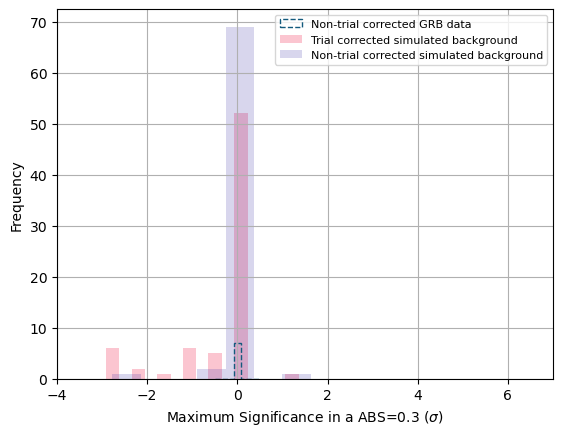

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
from scipy.stats import kstest,gaussian_kde,chi2
PSF = [0.3]
j = 2
sig_name = 'sigma_post'
Fisher_T_statistics={'PSF':[],'T_stat':[],'n_elem':[],'Crit_val':[]}
def normal_fixedA(x, mu, sigma, A0):
    """Gaussian with amplitude A0 fixed externally."""
    return A0 * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

for i in PSF:
    name_1 = f'Files/Min/grb_all_seed_min_PSF{i}_free.csv'
    df_1 = pd.read_csv(name_1)

    name_2 = f'Files/Min/grb_all_seed_min_PSF{i}_fixed.csv'
    df_2 = pd.read_csv(name_2)

    
    name_3 = f'Files/Min/grb_all_seed_min_PSF{i}_free_data.csv'
    df_3 = pd.read_csv(name_3)
    
    name_4 = f'Files/Min/grb_all_seed_min_PSF{i}_fixed_data.csv'
    df_4 = pd.read_csv(name_4)
    
    j = j + 1
    data = df_1[sig_name]

    # Describing  the data
    mu = data.mean()
    std = data.std()
    S = data.skew()
    K = data.kurt()
    Tstat, p_value = kstest(data, 'norm', args=(mu, std))

    hist, bins = np.histogram(data,bins=8,density=True)
    A0 = hist.max()
    mu0 = data.mean()
    sigma0 = data.std()
    centers = 0.5 * (bins[:-1] + bins[1:]) 
    popt, pcov = curve_fit(
        lambda x, mu, sigma: normal_fixedA(x, mu, sigma, A0),
        centers,
        hist,
        p0=[mu0, sigma0]
    )
    mu_fit, sigma_fit = popt
    x_fit = np.linspace(centers.min(), centers.max(), 2000)

    # --- Non-parametric density estimate and visualization ---


    # Build a kernel-density estimate from the same data
    kde = gaussian_kde(data, bw_method=0.35)  # or 'silverman' / float for bandwidth
    x_kde = np.linspace(data.min() - 1, data.max() + 1, 400)
    y_kde = kde(x_kde)
    def pdf(x):
        return(float(kde([x])))
    p_val_right=scipy.integrate.quad(pdf,3,np.inf,limit=200)[0]
    p_val_right=scipy.integrate.quad(pdf,2,3,limit=200)[0]
    p_val=()
    print('The probability of having values greater than 3 sigma with the non-parametric distribution  is:',p_val_right)
    print('and directly from data is:',len(data[data>3])/len(data))
    # Overlay the KDE curve
    # plt.plot(
    #     x_kde,
    #     y_kde,
    #     color='#48137d',
    #     lw=2,
    #     label='Non-parametric fit using KDE method'
    # )
    #gaussian fit

    df_4[sig_name].hist(
        bins=7,
        histtype='step',            # <-- outline only
        linewidth=1,  
        ls='dashed',# optional: thicker lines
        color='#135a7d',
        label='Non-trial corrected GRB data',
        density=True
    )
    ########################################################################
    # Fisher Test
    ########################################################################
    def PVal(x_data):
        p_val=-2*np.log(scipy.integrate.quad(kde,x_data,np.inf,limit=200)[0])
        return p_val
    GRB_data=df_4[sig_name]
    #Calculating T statistic
    # Fisher_statistic=GRB_data.apply(PVal).sum();n_elem=len(GRB_data) 
    # #Finding the critical value
    # Crit_val=chi2.ppf(0.95,2*n_elem)
    # Fisher_T_statistics['PSF'].append(i)
    # Fisher_T_statistics['T_stat'].append(Fisher_statistic)
    # Fisher_T_statistics['n_elem'].append(n_elem)
    # Fisher_T_statistics['Crit_val'].append(Crit_val)
    # plt.plot(x_fit,
    #         normal_fixedA(x_fit, mu_fit, sigma_fit, A0),
    #         "b-")

    # plt.hist(data,bins=bins,
    #         color=f'#f{j}4266',
    #         alpha=0.3,
    #         label=fr'max(PSF,Fermi_error),S={S:.2f},K={K:.2f},stat_KS={Tstat:.2f},p$_v$={p_value:.2f}',
    #         density=True,width=0.3)
    plt.hist(data,bins=bins,
            color=f'#f{j}4266',
            alpha=0.3,
            label=fr'Trial corrected simulated background',
            density=False,width=0.3)

    df_2[                  sig_name].hist(bins=7,
                        color=f'#{j}e32a8',  
                        alpha=0.2,
                        label='Non-trial corrected simulated background',
    density=False)
    # df_3[                  sig_name].hist(bins=7,
    #                     color=f'#27DAF5',  
    #                     alpha=0.2,
    #                     label='Trial corrected GRB data',
    # density=True)
    plt.legend(fontsize='8')
    plt.xlim([-4,7])
    plt.ylabel('Frequency')
    plt.xlabel(fr'Maximum Significance in a ABS={i} ($\sigma$) ')
    plt.savefig(f"plots/PSF{i}_wData.png", dpi=300, bbox_inches='tight')
    plt.show()
Fisher_Test=pd.DataFrame(Fisher_T_statistics)


In [8]:
df_1[sig_name]

0     0.011125
1     0.002634
2    -0.108624
3    -1.037772
4    -0.005245
        ...   
68   -0.014028
69   -0.011872
70   -0.027310
71   -0.014089
72    0.001844
Name: sigma_post, Length: 73, dtype: float64